# Eaglesong

In this notebook, we will cover the essentials of building a telegram bots with `eaglesong` library. This library was written in the year 2017 with the main focus on readable and easy-to-modify charflows. Telegram, as well as other messengers, offer the "per request" approach: the chatbot is given the incoming message and must produce the result. However, in case of longer conversations, it is easier to code the process from the chatbot's point of view: say this, listen to human, parse the input, say something else. `eaglesong` provides exactly this possibility. 

`eaglesong` uses the `yield` approach. Some people suggested it can be replaced with `async/await`, keeping the logic of the conversation flow intact. Some people however offered arguments why these approaches, although similar and based on the same design pattern, are not equivalent in Python and hence `async/await` cannot be used in this particular case. Unfortunately, my understanding of `async/await` does not allow me to answer this question with certainty. This notebook and the examples offer a comprehensive list of scenarios of how `eaglesong` is used for Telegram, and therefore a good test base for `async/await` implementation attempts.


Unfortunately, Telegram bot cannot be run from the notebook. So the runnable examples are in `/demos/eaglesong`. This notebook will demonstrate and explain the scenarios, and run them with the testing utility.

Before running the bots from `demos/eaglesong`, you will need:

1. Contact `@BotFather` bot on Telegram and register your chatbot. As the result, you will obtain an API key that looks like this: `0000000000:xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx`
2. Create an `environment.env` file in the repository's root. This file is already in `.gitignore`, so don't be afraid to accidentaly push its contents.
3. Place `KAIA_TEST_BOT=<YOUR_API_KEY>` in the `environment.env` file.

After these actions, the next cell should execute with "Success" output and without throwing an error:

In [1]:
from kaia.infra import Loc
import os 

assert 'KAIA_TEST_BOT' in os.environ, 'Bot API KEY was not found'
print('Success')

Success


## Simplest chatflow

Let's start with the simplest chatbot: it greets you and then replies your messages back to you.

In [2]:
from typing import *
from kaia.eaglesong.telegram import TgCommand, TgUpdate
from kaia.eaglesong.arch import  Listen

def echo(context: Callable[[], TgUpdate]):
    yield TgCommand.mock().send_message(
        chat_id = context().chat_id,
        text=f'Hi {context().update.message.from_user.name}! Say anything and I will repeat.'
    )
    
    while True:
        yield Listen()
        input_text = context().update.message.text
        yield TgCommand.mock().send_message(context().chat_id, input_text)

The chatbot is defined by a single function, that takes the context. The `context` is used to retrieve the message that was sent to you at the time. Since this function covers the entire process of communication, `context()` will return different messages at the different lines of code.

To say something, you `yield` a command, for instance, a telegram command `TgCommand`. This is essentially the instruction to invoke a method with a specified name from the `bot` with the passed parameters. You may of course create it manually:

In [3]:
c = TgCommand('send_message', 0, 'test')
print(c)
c.__dict__

{'bot_method': 'send_message',
 'args': (0, 'test'),
 'kwargs': {},
 '_ignore_errors': False}

But it's easier to do with `TgCommand.mock()`:

In [4]:
c = TgCommand.mock().send_message(0, 'test')
print(c)
c.__dict__

{'bot_method': 'send_message',
 'args': (0, 'test'),
 'kwargs': {},
 '_ignore_errors': False}

`mock()` method returns a factory that creates `TgCommand` but _pretends_ to return a `Bot`. So your IDE is tricked to show you a documentation to all telegram bot's methods (press Shift-Tab to access hints in Jupyter notebooks):

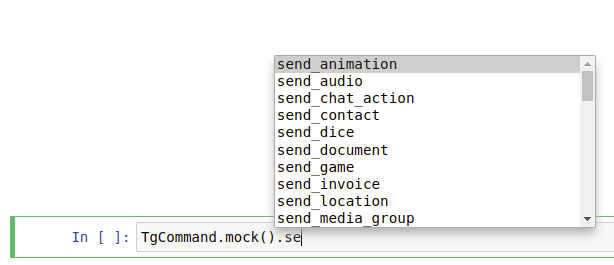

In [5]:
from IPython.display import Image

Image('files/mock_hints.png')

The rest of the function is inside `while`: bot yields a `Listen` command, indicating that it stopped sending messages and now is waiting for the user's input. So, the method is "stopped" at this moment (how exactly `eaglesong` processes this is beyond this demo, the important thing is that it works). After the user has sent a message to the bot, the method is "resumed" directly after `yield Listen()` line, and `context()` will return the recent user's message at this point. Then, the bot repeats the message's text.

### Testing scenarios

As mentioned, we cannot run `echo` as the Telegram bot from the notebook due to technical reasons. However, we can run it in the testbed. As the input, we will provide it with the same messages, as Telegram would send. They are pretty complicated, so we use a class designed to create some of the simplest messages:

In [6]:
from kaia.eaglesong.telegram import TelegramTestProvider


tp = TelegramTestProvider(chat_id=100, username='me')
tp.text('Hi').__dict__

{'chat_id': 100,
 'type': <Type.Text: 1>,
 'update': Update(message=Message(channel_chat_created=False, chat=Chat(id=100, type=<ChatType.PRIVATE>), date=datetime.datetime(2023, 3, 24, 15, 11, 15, 704194), delete_chat_photo=False, from_user=User(first_name='me', id=1, is_bot=False), group_chat_created=False, message_id=2, supergroup_chat_created=False, text='Hi'), update_id=2),
 'context': None,
 'last_return': None,
 'is_continuation': False}

Now, we can use the scenario to debug the chatflow:

In [7]:
from kaia.eaglesong.arch import Scenario

print(TelegramTestProvider.visualize(
    Scenario()
    .send(tp.start())
    .send(tp.text('Hello'))
    .send(tp.text('Hi'))
    .validate(echo)
))

> {"update_id": 3, "message": {"chat": {"id": 100, "type": "private"}, "text": "/start", "group_chat_created": false, "message_id": 3, "delete_chat_photo": false, "date": 1679670675, "supergroup_chat_created": false, "channel_chat_created": false, "from": {"is_bot": false, "first_name": "me", "id": 1}}}
  < send_message(chat_id = 100, text = Hi me! Say anything and I will repeat.)
> {"update_id": 4, "message": {"chat": {"id": 100, "type": "private"}, "text": "Hello", "group_chat_created": false, "message_id": 4, "delete_chat_photo": false, "date": 1679670675, "supergroup_chat_created": false, "channel_chat_created": false, "from": {"is_bot": false, "first_name": "me", "id": 1}}}
  < send_message(100, Hello)
> {"update_id": 5, "message": {"chat": {"id": 100, "type": "private"}, "text": "Hi", "group_chat_created": false, "message_id": 5, "delete_chat_photo": false, "date": 1679670675, "supergroup_chat_created": false, "channel_chat_created": false, "from": {"is_bot": false, "first_name":

The name `validate` suggests we can actually check if it behaves correctly. If you uncomment the last check, the code with throw an exception.

In [8]:
(
    Scenario()
    .send(tp.start())
    .check(lambda z: 'Hi me!' in z.kwargs['text'])
    .send(tp.text('Hello'))
    .check(lambda z: z.args[1]=='Hello')
    .send(tp.text('Hi'))
    #.check(lambda z: z.args[1]=='Hi!')
    .validate(echo)
)
pass

## Questionnaire chatflow

The following code demonstrates how to write several questions one after another, and also how one chat flow may invoke another:

In [9]:
from kaia.eaglesong.arch import FunctionalSubroutine, Return

def questionnaire(c: Callable[[], TgUpdate]):
    yield TgCommand.mock().send_message(c().chat_id, 'What is your name?')
    yield Listen()
    name = c().update.message.text

    yield TgCommand.mock().send_message(c().chat_id, f'Where are you from, {name}?')
    yield Listen()
    country = c().update.message.text

    yield Return(name, country)

def main(c: Callable[[], TgUpdate]):
    subroutine = FunctionalSubroutine(questionnaire)
    yield subroutine
    name, country = subroutine.returned_value()

    yield TgCommand.mock().send_message(c().chat_id, f"Nice to meet you, {name} from {country}!")
    
print(TelegramTestProvider.visualize(
    Scenario()
    .send(tp.start())
    .send(tp.text('Adam'))
    .check(lambda z: 'Adam?' in z.args[1])
    .send(tp.text('USA'))
    .check(
        lambda z: 'Adam from USA' in z.args[1],
        lambda z: isinstance(z,Return)
    )
    .validate(main)
))

> {"update_id": 9, "message": {"chat": {"id": 100, "type": "private"}, "text": "/start", "group_chat_created": false, "message_id": 9, "delete_chat_photo": false, "date": 1679670675, "supergroup_chat_created": false, "channel_chat_created": false, "from": {"is_bot": false, "first_name": "me", "id": 1}}}
  < send_message(100, What is your name?)
> {"update_id": 10, "message": {"chat": {"id": 100, "type": "private"}, "text": "Adam", "group_chat_created": false, "message_id": 10, "delete_chat_photo": false, "date": 1679670675, "supergroup_chat_created": false, "channel_chat_created": false, "from": {"is_bot": false, "first_name": "me", "id": 1}}}
  < send_message(100, Where are you from, Adam?)
> {"update_id": 11, "message": {"chat": {"id": 100, "type": "private"}, "text": "USA", "group_chat_created": false, "message_id": 11, "delete_chat_photo": false, "date": 1679670675, "supergroup_chat_created": false, "channel_chat_created": false, "from": {"is_bot": false, "first_name": "me", "id": 

## Authorization chatflow


Some chatflows could be reused and are therefore packages as classes (inheriting `Subroutine` class). Basically it's the same chatflow function as we have already seen, but written inside `run` method of the `Subroutine` subclass.

These can be used as follows:

In [10]:
from kaia.eaglesong.amenities.authorize import Authorization

def main(c):
    yield Authorization('1234', 'files/auth')
    yield TgCommand.mock().send_message(c().chat_id, 'Hi!')
    while True:
        yield Listen()
        yield TgCommand.mock().send_message(c().chat_id, c().update.message.text)
    

Authorization accepts a pin (I would suggest using last 4 letters of your bot's API key) and a path where the authorization file will be stored. Let's delete this file and run a happy path:

In [11]:
import os

if os.path.isfile('files/auth'):
    os.remove('files/auth')

print(TelegramTestProvider.visualize(
    Scenario()
    .send(tp.start())
    .check(lambda z: 'Enter pin' in z.args[1])
    .send(tp.text('1234'))
    .check(
        lambda z: 'Authorized' in z.args[1],
        lambda z: 'Hi!' in z.args[1]
    )
    .send(tp.text('Hello'))
    .check(lambda z: z.args[1]=='Hello')
    .validate(main)
))

> {"update_id": 12, "message": {"chat": {"id": 100, "type": "private"}, "text": "/start", "group_chat_created": false, "message_id": 12, "delete_chat_photo": false, "date": 1679670675, "supergroup_chat_created": false, "channel_chat_created": false, "from": {"is_bot": false, "first_name": "me", "id": 1}}}
  < send_message(100, Enter pin to authorize)
> {"update_id": 13, "message": {"chat": {"id": 100, "type": "private"}, "text": "1234", "group_chat_created": false, "message_id": 13, "delete_chat_photo": false, "date": 1679670675, "supergroup_chat_created": false, "channel_chat_created": false, "from": {"is_bot": false, "first_name": "me", "id": 1}}}
  < send_message(100, Authorized)
  < send_message(100, Hi!)
> {"update_id": 14, "message": {"chat": {"id": 100, "type": "private"}, "text": "Hello", "group_chat_created": false, "message_id": 14, "delete_chat_photo": false, "date": 1679670675, "supergroup_chat_created": false, "channel_chat_created": false, "from": {"is_bot": false, "first

Now, let's try to initiate the dialog from a different chat:

In [12]:
from kaia.eaglesong.arch import Terminate

tp1 = TelegramTestProvider(101, 'not me')

print(TelegramTestProvider.visualize(
    Scenario()
    .send(tp1.start())
    .check(lambda z: isinstance(z, Terminate))
    .validate(main)
))    

> {"update_id": 2, "message": {"chat": {"id": 101, "type": "private"}, "text": "/start", "group_chat_created": false, "message_id": 2, "delete_chat_photo": false, "date": 1679670675, "supergroup_chat_created": false, "channel_chat_created": false, "from": {"is_bot": false, "first_name": "not me", "id": 1}}}
  < <kaia.eaglesong.arch.automaton.Terminate object at 0x7f03dc551af0>


So, this Authorization only authorizes one user, and everyone else will receive a `Terminate` response, which will terminate the chatflow for them immediately.

## Other chatflows

* `eaglesong/part_04_menu.py` offers a menu with buttons, as well as an example of a web-request inside one of the selectable options. 